In [1]:
import mx_layers as layers
network = layers.variable('data')
_convolution = lambda X : layers.convolution(X=X, n_filters=16, kernel_shape=(5, 5), stride=(1, 1), pad=(2, 2))
for i in range(3):
    network = _convolution(network)
    network = layers.ReLU(network)
    network = layers.pooling(X=network, mode='maximum', kernel_shape=(2, 2), stride=(2, 2), pad=(0, 0))

n_layers = 2
_convolution = lambda X : layers.convolution(
    X=X, n_filters=16, kernel_shape=(3, 3), stride=(1, 1), pad=(1, 1), weight=shared_weight, no_bias=True
)
shared_weight = layers.variable('shared_weight')
shared_gamma = layers.variable('shared_gamma')
shared_beta = layers.variable('shared_beta')
for i in range(n_layers):
    network = layers.batch_normalization(network, gamma=shared_gamma, beta=shared_beta, fix_gamma=False)
    network = layers.ReLU(network)
    network += _convolution(network)

network = layers.pooling(X=network, mode='maximum', kernel_shape=(7, 7), stride=(1, 1), pad=(0, 0))
network = layers.flatten(network)
network = layers.fully_connected(X=network, n_hidden_units=10)

In [2]:
import cPickle as pickle
parameters, states = pickle.load(open('parameters/residual-network-on-shrinked-mnist-%d-round-1' % n_layers, 'rb'))

In [3]:
from data_utilities import load_mnist
# original = load('stretched_canvas_mnist/mnist')
original = load_mnist('stretched_canvas_mnist/', scale=1, shape=(1, 56, 56))
stretched = load_mnist('stretched_mnist/', scale=1, shape=(1, 56, 56))

In [4]:
import mxnet as mx
context = mx.cpu()
args = {key : mx.nd.array(value, context) for key, value in parameters.items()}
n_samples = 10
args['data'] = mx.nd.array(original[4][:n_samples], context)
args_grad = {'data' : mx.nd.zeros_like(args['data'])}
aux_states = {key : mx.nd.array(value, context) for key, value in states.items()}

In [5]:
executor = network.bind(context, args, args_grad=args_grad, aux_states=aux_states)

In [6]:
import numpy as np
scores = executor.forward(is_train=True)[0].asnumpy()
upstream = np.zeros_like(scores)
upstream[:, original[5][:n_samples]] = 1
executor.backward(mx.nd.array(upstream, context))
from_labeled = args_grad['data'].asnumpy().reshape((n_samples, 56, 56))
predictions = np.argmax(scores, axis=1)
upstream[:] = 0
upstream[:, predictions] = 1
executor.forward(is_train=True)
executor.backward(mx.nd.array(upstream, context))
from_predicted = args_grad['data'].asnumpy().reshape((n_samples, 56, 56))

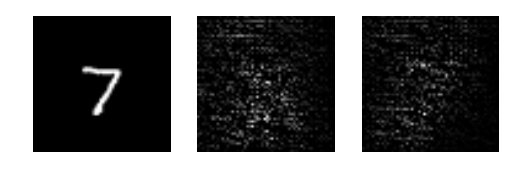

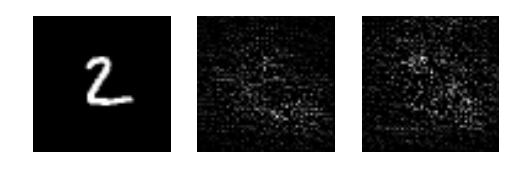

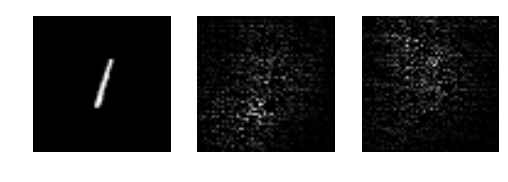

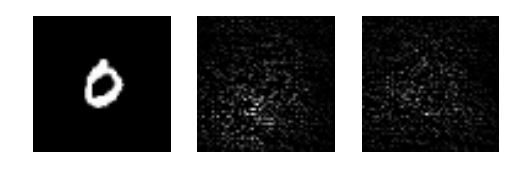

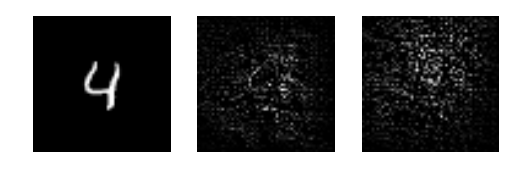

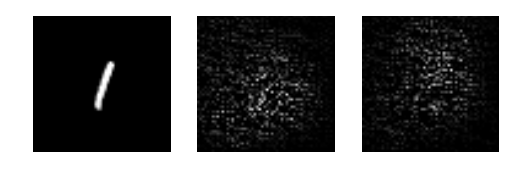

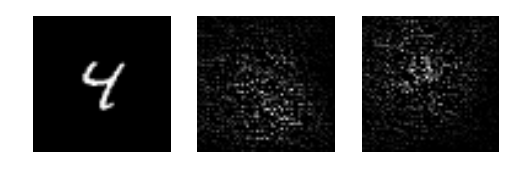

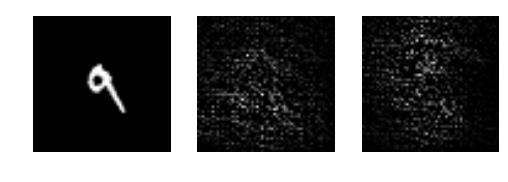

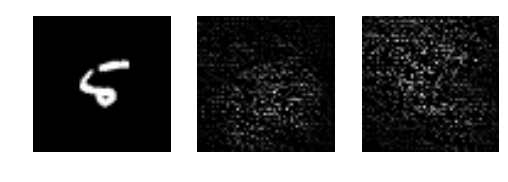

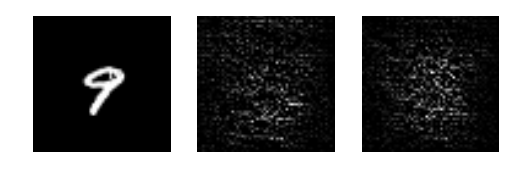

In [7]:
import matplotlib.pylab as pl
%matplotlib inline
pre = lambda X : np.maximum(0, X.reshape((56, 56)))
for i in range(n_samples):
    f, axes = pl.subplots(1, 3)
    axes[0].imshow(original[4][i].reshape((56, 56)), cmap='gray')
    axes[0].axis('off')
    axes[1].imshow(pre(from_labeled[i]), cmap='gray')
    axes[1].axis('off')
    axes[2].imshow(pre(from_predicted[i]), cmap='gray')
    axes[2].axis('off')